This script will run the ak and canada models together

Read in packages

In [2]:
import pandas as pd
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.python.lib.io import file_io
from tensorflow.python.keras.optimizer_v2.adam import Adam
import os
import segmentation_models as sm
import matplotlib.pyplot as plt
import numpy as np
#from tensorflow.python.keras.utils.multi_gpu_utils import multi_gpu_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Dropout,Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.layers import concatenate, Conv2DTranspose, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, Input, AvgPool2D
from tensorflow.keras.models import Model
from keras_unet_collection import models
import tensorflow_addons as tfa
import logging
# from tensorflow import tensorflow.keras.mixed_precision.set_global_policy("mixed_float16")

Function to read in the validation and testing data for all four scenarios, landsat only no threshold, landsat threshold,


In [3]:


#----------projected with negative nbac training 128
land_sent_128_val = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_sent_collection2_proj_0_128_validation_files.csv')['Files'].tolist()
land_sent_128_test = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_sent_collection2_proj_0_128_testing_files.csv')['Files'].tolist()

#mtbs files to test on 
land_sent_mtbs_128_train = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_sent_collection2_proj_mtbs_0_128_training_files.csv')['Files'].tolist()
land_sent_mtbs_128_val = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_sent_collection2_proj_mtbs_0_128_validation_files.csv')['Files'].tolist()
land_sent_mtbs_128_test = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_sent_collection2_proj_mtbs_0_128_testing_files.csv')['Files'].tolist()


mtbs = land_sent_mtbs_128_train + land_sent_mtbs_128_val + land_sent_mtbs_128_test

#function to get files from storage bucket
def get_files(bucket_path):

  """argument is the path to where the numpy
  save files are located, return a list of filenames
  """
  all = []

  #list of files
  files = os.listdir(bucket_path)

  #get list of filenames we will use, notte I remove images that don't have a target due to clouds
  file_names = []
  for f in files:
    if f.endswith('.npy'):


      all.append(os.path.join(bucket_path, f))
  return(all)
  





Set up image generator

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

min_max = pd.read_csv("/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_sent_collection2_global_min_max_cutoff_proj.csv").reset_index(drop = True)
min_max = min_max[['6']]

class img_gen(tensorflow.keras.utils.Sequence):

    """Helper to iterate over the data (as Numpy arrays).
    Inputs are batch size, the image size, the input paths (x) and target paths (y)
    """

    #will need pre defined variables batch_size, img_size, input_img_paths and target_img_paths
    def __init__(self, batch_size, img_size, input_img_paths):
	    self.batch_size = batch_size
	    self.img_size = img_size
	    self.input_img_paths = input_img_paths
	    self.target_img_paths = input_img_paths

    #number of batches the generator is supposed to produceis the length of the paths divided by the batch siize
    def __len__(self):
	    return len(self.input_img_paths) // self.batch_size

    def __getitem__(self, idx):
        
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_img_paths = self.input_img_paths[i : i + self.batch_size] #for a given index get the input batch pathways (x)
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size] #for a given index get the input batch pathways (y)
		
        x = np.zeros((self.batch_size,) + self.img_size, dtype="float32") #create matrix of zeros which will have the dimension (batch_size, height, wideth, n_bands), 8 is the n_bands
        
  
        #start populating x by enumerating over the input img paths
        for j, path in enumerate(batch_img_paths):

            #load image
            img =  np.round(np.load(path), 3)[:, :, 6]

            # img = img * 1000
            img = img.astype(float)
            img = np.round(img, 3)
            img[img == 0] = -999

            img[np.isnan(img)] = -999


            img[img == -999] = np.nan

            in_shape = img.shape

            #turn to dataframe to normalize
            img = img.reshape(img.shape[0] * img.shape[1])

            img = pd.DataFrame(img)

            img.columns = min_max.columns

            img = pd.concat([min_max, img]).reset_index(drop = True)


            #normalize 0 to 1
            img = pd.DataFrame(scaler.fit_transform(img))

            img = img.iloc[2:]
#
#             img = img.values.reshape(in_shape)
            img = img.values.reshape(in_shape)

#             replace nan with -1
            img[np.isnan(img)] = -1

#apply standardization
# img = normalize(img, axis=(0,1))

            img = np.round(img, 3)
            #populate x
            x[j] = img#[:, :, 4:] index number is not included, 


        #do tthe same thing for y
        y = np.zeros((self.batch_size,) + self.img_size, dtype="uint8")

        for j, path in enumerate(batch_target_img_paths):

            #load image
            img =  np.round(np.load(path), 3)[:, :, -1]

            img = img.astype(int)

            img[img < 0] = 0
            img[img >1] = 0
            img[~np.isin(img, [0,1])] = 0

            img[np.isnan(img)] = 0
            img = img.astype(int)

            # img =  tf.keras.utils.to_categorical(img, num_classes = 2)
            # y[j] = np.expand_dims(img, 2) 
            y[j] = img
  
       
    #Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
    # y[j] -= 1

        return x, y

Read in the images based on the generator

In [17]:
#batch size and img size
BATCH_SIZE = 15
GPUS = ["GPU:0", "GPU:1", "GPU:2", "GPU:3"]
strategy = tensorflow.distribute.MirroredStrategy() #can add GPUS here to select specific ones
print('Number of devices: %d' % strategy.num_replicas_in_sync) 

batch_size = BATCH_SIZE * strategy.num_replicas_in_sync

#image size
img_size = (128, 128)

#number of classes to predict
num_classes = 1

#nbac testing
land_sent_128_testing_gen =  img_gen(batch_size, img_size, land_sent_128_test)

#mtbs
mtbs_gen =  img_gen(batch_size, img_size, mtbs)



Number of devices: 4


Get the best validation Iou

In [8]:
#----landsat and sentinel nbac val score
land_sent_128_best_val = pd.read_csv("/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_collection2_dnbr_one_128_2d_ds_proj.csv")
land_sent_128_max = land_sent_128_best_val[land_sent_128_best_val['Val_IOU'] == land_sent_128_best_val['Val_IOU'].max()]['Val_IOU'].values
print(f"Landsat Sentinal NBAC 128 validation IoU is {land_sent_128_max}")



Landsat Sentinal NBAC 128 validation IoU is [0.84584069]


Read in all the models

In [11]:
# #-------landsat 8
land_sent_128_model = tensorflow.keras.models.load_model("/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/models/l8_collection2_dnbr_one_128_2d_ds_proj.tf", 
                                           custom_objects={'precision':sm.metrics.Precision(threshold=0.5), 
                                                           'recall':sm.metrics.Recall(threshold = 0.5),
                                                            'f1-score': sm.metrics.FScore(threshold=0.5),
                                                             'iou_score': sm.metrics.IOUScore(threshold=0.5)})




Get all the testing scores for nbac

In [18]:
#landsat 
land_sent_128_res = land_sent_128_model.evaluate_generator(land_sent_128_testing_gen, 100)

print(f"Landsat Sentinel 128 testing IoU is {land_sent_128_res[-1]}")


/tmp/ipykernel_1471212/2026950408.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  land_sent_128_res = land_sent_128_model.evaluate_generator(land_sent_128_testing_gen, 100)


Landsat 128 testing IoU is 0.854518711566925


Now get mtbs

In [19]:
mtbs_res = land_sent_128_model.evaluate_generator(mtbs_gen, 100)

print(f"Landsat Sentinel MTBS 128 IoU is {mtbs_res[-1]}")

/tmp/ipykernel_1471212/142773049.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  mtbs_res = land_sent_128_model.evaluate_generator(mtbs_gen, 100)


Landsat Sentinel MTBS 128 IoU is 0.7857493758201599


In [5]:
modis_0_max = modis_0[modis_0['Val_Accuracy'] == modis_0['Val_Accuracy'].max()]['Val_Accuracy'].values
print(f"MODIS 0  Accuracy is {modis_0_max}")

MODIS 0  Accuracy is [0.99950033]


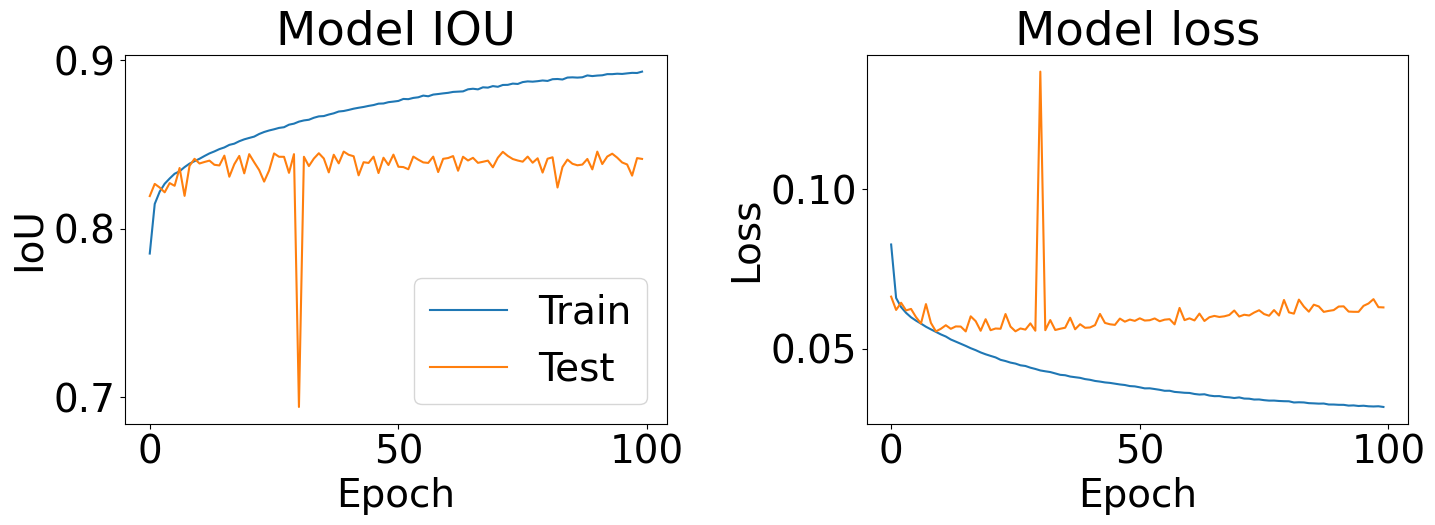

In [6]:
import matplotlib
font = {'family' : 'normal',
        'size'   : 28}

df = pd.read_csv("/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/modis_dnbr_0_five_plus_128_2d_ds_aug.csv")
df = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_collection2_dnbr_one_128_2d_ds_proj.csv')
# df = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_collection2_dnbr_one_128_2d_ds_long_neg.csv')
#l8_sent_collection2_crop_dnbr_0_two_long_128.csv
#l8_sent_collection2_crop_dnbr_0_two_long_128_neg_aug.csv
matplotlib.rc('font', **font)

#plot the curves
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.plot(df['IOU'])
plt.plot(df['Val_IOU'])
plt.title("Model IOU")
plt.ylabel('IoU')
plt.xlabel('Epoch')
# plt.ylim(0, 1)
# plt.xlim(40,70)
plt.legend(['Train', 'Test'], loc='lower right')


# Plot training & validation loss values
plt.subplot(222)
plt.plot(df['Loss'])
plt.plot(df['Val_Loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.ylim(0, 1)
# plt.legend(['Train', 'Test'], loc='upper left')


# plt.subplot(223)
# plt.plot(df['F1'])
# plt.plot(df['Val_F1'])
# plt.title('Model F1')
# plt.ylabel('F1')
# plt.xlabel('Epoch')
# plt.ylim(0, 1)
plt.tight_layout()

# plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# plt.subplot(122)
# plt.plot(df['Loss'])
# plt.plot(df['Val_Loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.ylim(0, 1)
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()